## Install Require Libraries


In [110]:
!pip install xgboost
!pip install tensorflow
!pip install keras

## Import Libraries

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

## Load Dataset

In [112]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [113]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [115]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Feature Engineering

In [116]:
# create group column
train['Group'] = train['PassengerId'].str.split('_').str[1]
# Create a new column 'TotalExpenditure' by summing all expenditure columns
train['TotalExpenditure'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
# Split the 'Cabin' column into 'Deck', 'Num', and 'Side'
train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
# Convert the 'Num' column to numeric
train['Num'] = pd.to_numeric(train['Num'], errors='coerce')


## handling missing values

In [117]:
for column in train.columns:
    unique_values = train[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print("\n")

Column: PassengerId
Unique Values: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']


Column: HomePlanet
Unique Values: ['Europa' 'Earth' 'Mars' nan]


Column: CryoSleep
Unique Values: [False True nan]


Column: Cabin
Unique Values: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']


Column: Destination
Unique Values: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


Column: Age
Unique Values: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]


Column: VIP
Unique Values: [False True nan]


Column: RoomService
Unique Values: [   0.  109.   43. ... 1569. 8586.  745.]


Column: FoodCourt
Unique Values: [   0.    9. 3576. ... 3208. 6819. 4688.]


Column: ShoppingMall
Unique Values: [ 

#### HomePlanet

In [118]:
# Fill missing 'HomePlanet' values based on the most common HomePlanet within each group
for group in train['Group'].unique():
    mode_homeplanet = train.loc[train['Group'] == group, 'HomePlanet'].mode()
    if not mode_homeplanet.empty:
        train.loc[(train['Group'] == group) & (train['HomePlanet'].isnull()), 'HomePlanet'] = mode_homeplanet[0]

#### Cryosleep

In [119]:
# Fill missing 'CryoSleep' values based on 'TotalExpenditure'
# If 'TotalExpenditure' is 0, set 'CryoSleep' to True; otherwise, set to False
train.loc[train['CryoSleep'].isnull(), 'CryoSleep'] = train['TotalExpenditure'] == 0

#### Cabin

In [120]:
# Fill missing 'Deck' and 'Side' values using the mode within each group
for group in train['Group'].unique():
    mode_deck = train.loc[train['Group'] == group, 'Deck'].mode()
    mode_side = train.loc[train['Group'] == group, 'Side'].mode()
    
    if not mode_deck.empty:
        train.loc[(train['Group'] == group) & (train['Deck'].isnull()), 'Deck'] = mode_deck[0]
    if not mode_side.empty:
        train.loc[(train['Group'] == group) & (train['Side'].isnull()), 'Side'] = mode_side[0]

# Impute 'Num' with a simple strategy, like filling with the median
train['Num'] = train['Num'].fillna(train['Num'].median())

# Combine 'Deck', 'Num', and 'Side' back into 'Cabin'
train['Cabin'] = train['Deck'] + '/' + train['Num'].astype(str) + '/' + train['Side']

#### Destination

In [121]:
# Fill missing 'Destination' values based on the most common value within each group
for group in train['Group'].unique():
    mode_destination = train.loc[train['Group'] == group, 'Destination'].mode()
    
    if not mode_destination.empty:
        train.loc[(train['Group'] == group) & (train['Destination'].isnull()), 'Destination'] = mode_destination[0]

#### Age

In [122]:
# Fill missing 'Age' values using the median within each 'HomePlanet'
for planet in train['HomePlanet'].unique():
    median_age = train.loc[train['HomePlanet'] == planet, 'Age'].median()
    train.loc[(train['HomePlanet'] == planet) & (train['Age'].isnull()), 'Age'] = median_age

#### VIP

In [123]:
# Fill missing 'VIP' values with the most frequent value (mode)
train['VIP'].fillna(train['VIP'].mode()[0], inplace=True)

/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/3741404019.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['VIP'].fillna(train['VIP'].mode()[0], inplace=True)
/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/3741404019.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


#### 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'


In [124]:
# Calculate 1/5 of 'TotalExpenditure'
expenditure_fraction = train['TotalExpenditure'] / 5

# Fill missing values in each spending-related column with 1/5 of 'TotalExpenditure'
train['RoomService'].fillna(expenditure_fraction, inplace=True)
train['FoodCourt'].fillna(expenditure_fraction, inplace=True)
train['ShoppingMall'].fillna(expenditure_fraction, inplace=True)
train['Spa'].fillna(expenditure_fraction, inplace=True)
train['VRDeck'].fillna(expenditure_fraction, inplace=True)

/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/1701282696.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RoomService'].fillna(expenditure_fraction, inplace=True)
/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/1701282696.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [125]:
train = train.drop(columns=['Name'])
train = train.drop(columns=['Cabin'])
train = train.drop(columns=['PassengerId'])

In [126]:
train.isnull().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
Group               0
TotalExpenditure    0
Deck                0
Num                 0
Side                0
dtype: int64

In [127]:
train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,TotalExpenditure,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,01,0.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,01,736.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,01,10383.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,02,5176.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,01,1091.0,F,1.0,S
5,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,01,774.0,F,0.0,P
6,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,01,1584.0,F,2.0,S
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,02,0.0,G,0.0,S
8,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,01,1018.0,F,3.0,S
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,01,0.0,B,1.0,P


### Feature Encoding

In [128]:
train['CryoSleep'] = train['CryoSleep'].astype(bool)

In [129]:
# Perform one-hot encoding on 'HomePlanet', 'Destination', 'Deck', 'Side' columns
train = pd.get_dummies(train, columns=['HomePlanet', 'Destination','Deck', 'Side','Group'])

In [130]:
# Define the bins and labels for the Age column
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-100']

# Create a new column 'AgeGroup' with the binned values
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)
train = train.drop(columns=['Age'])

# One-hot encode the 'AgeGroup' column
train = pd.get_dummies(train, columns=['AgeGroup'], prefix='AgeGroup')

In [131]:
# Identify all columns with boolean (True/False) values
boolean_columns = train.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 and 1)
train[boolean_columns] = train[boolean_columns].astype(int)
train.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalExpenditure,Num,...,Group_06,Group_07,Group_08,AgeGroup_0-18,AgeGroup_19-25,AgeGroup_26-35,AgeGroup_36-45,AgeGroup_46-55,AgeGroup_56-65,AgeGroup_66-100
0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,109.0,9.0,25.0,549.0,44.0,1,736.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,43.0,3576.0,0.0,6715.0,49.0,0,10383.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0.0,1283.0,371.0,3329.0,193.0,0,5176.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,303.0,70.0,151.0,565.0,2.0,1,1091.0,1.0,...,0,0,0,1,0,0,0,0,0,0


In [132]:
print(train.columns)

Index(['CryoSleep', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Transported', 'TotalExpenditure', 'Num', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S', 'Group_01', 'Group_02', 'Group_03', 'Group_04',
       'Group_05', 'Group_06', 'Group_07', 'Group_08', 'AgeGroup_0-18',
       'AgeGroup_19-25', 'AgeGroup_26-35', 'AgeGroup_36-45', 'AgeGroup_46-55',
       'AgeGroup_56-65', 'AgeGroup_66-100'],
      dtype='object')


## Exploratory Data Analysis

/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/2603699716.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train[train['Transported'] == 1]['TotalExpenditure'], label='Transported', shade=True)
/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/2603699716.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train[train['Transported'] == 0]['TotalExpenditure'], label='Not Transported', shade=True)


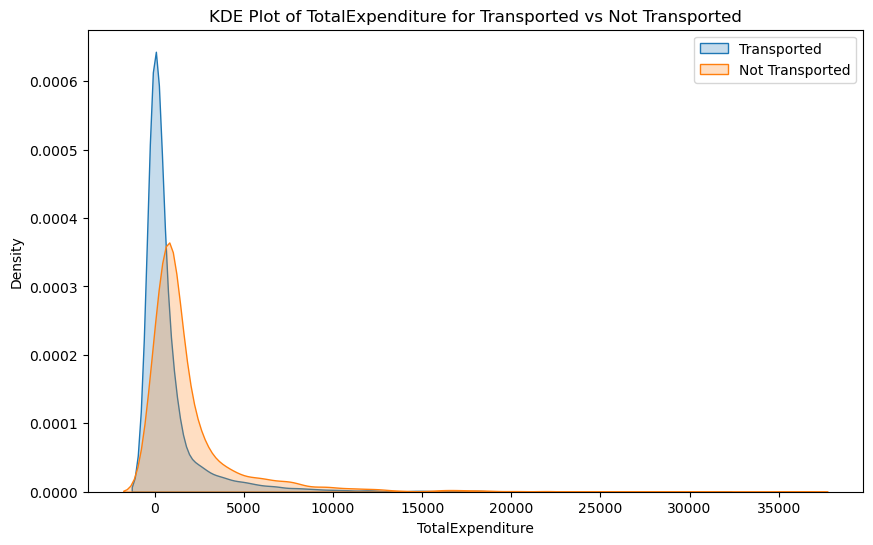

In [133]:
# Create a KDE plot to show the distribution of TotalExpenditure for both groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train[train['Transported'] == 1]['TotalExpenditure'], label='Transported', shade=True)
sns.kdeplot(data=train[train['Transported'] == 0]['TotalExpenditure'], label='Not Transported', shade=True)
plt.title('KDE Plot of TotalExpenditure for Transported vs Not Transported')
plt.xlabel('TotalExpenditure')
plt.ylabel('Density')
plt.legend()
plt.show()

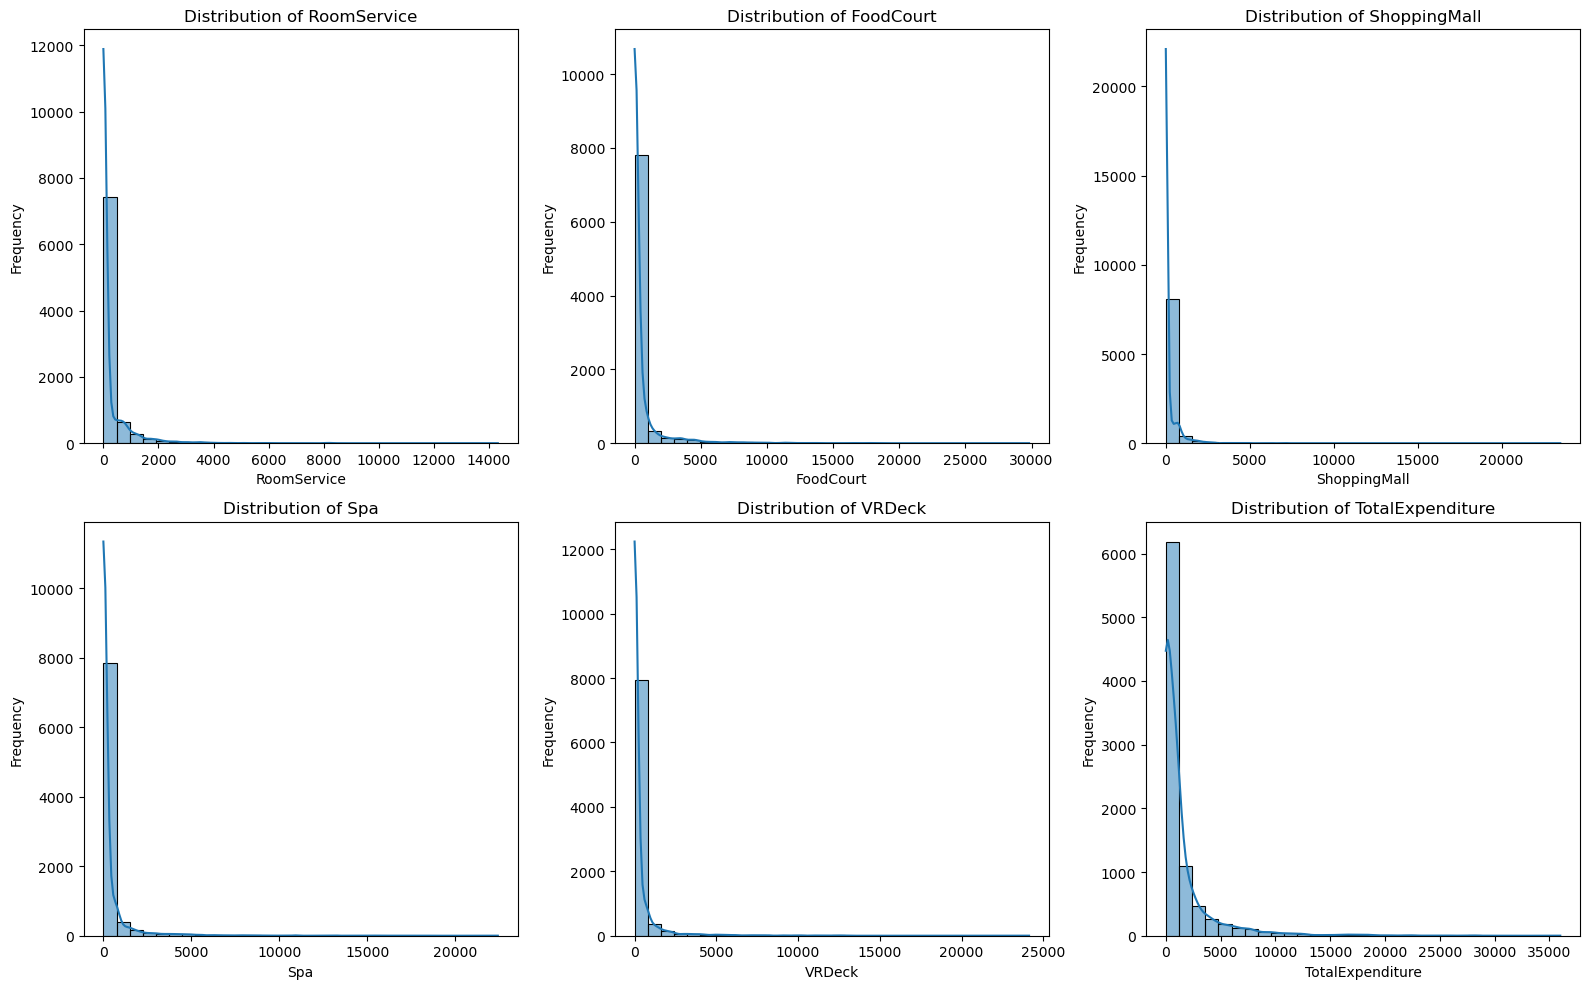

In [134]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenditure']

# Set up the matplotlib figure
plt.figure(figsize=(16, 10))

# Loop through each column and plot
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)  # Create subplots (2 rows, 3 columns)
    sns.histplot(data=train, x=column, kde=True, bins=30)  # Histogram with KDE
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

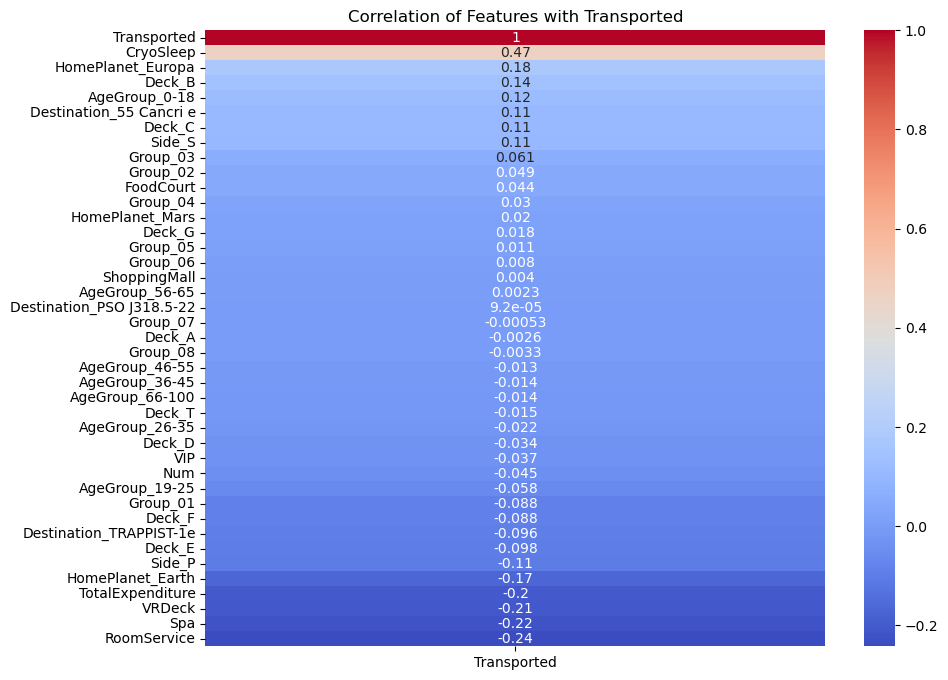

In [135]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the heatmap, focusing on the correlation with the 'Transported' column
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Transported']].sort_values(by='Transported', ascending=False), 
            annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation of Features with Transported')
plt.show()

In [136]:
print(train.columns.tolist())

['CryoSleep', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'TotalExpenditure', 'Num', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S', 'Group_01', 'Group_02', 'Group_03', 'Group_04', 'Group_05', 'Group_06', 'Group_07', 'Group_08', 'AgeGroup_0-18', 'AgeGroup_19-25', 'AgeGroup_26-35', 'AgeGroup_36-45', 'AgeGroup_46-55', 'AgeGroup_56-65', 'AgeGroup_66-100']


## Model Building


In [137]:
# Define X (features) and y (target variable)
selected_features = [col for col in train.columns if col not in ['Transported','AgeGroup_56-65','Destination_PSO J318.5-22', 'Group_06', 'Group_07']]
X = train[selected_features]  # Feature matrix
y = train['Transported']      # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6085, 36)
X_test shape: (2608, 36)
y_train shape: (6085,)
y_test shape: (2608,)


### XGBoost

In [138]:
# Define the XGBoost classifier with the best parameters
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=0.9,
    learning_rate=0.2,
    max_depth=5,
    n_estimators=200,
    subsample=0.9
)

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy: .3f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy:  0.803

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1289
           1       0.81      0.80      0.81      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608


Confusion Matrix:
 [[1033  256]
 [ 258 1061]]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Support Vector Machine

In [70]:
# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

# Train the model
svm_rbf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_rbf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.782

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1289
           1       0.78      0.80      0.79      1319

    accuracy                           0.78      2608
   macro avg       0.78      0.78      0.78      2608
weighted avg       0.78      0.78      0.78      2608


Confusion Matrix:
[[ 991  298]
 [ 270 1049]]


### Random Forest Classifier

In [71]:
# Initialize the Random Forest model with the best parameters
rf_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42  # You can specify a random seed for reproducibility
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Random Forest Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80      1289
           1       0.82      0.76      0.79      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608


Confusion Matrix:
 [[1061  228]
 [ 311 1008]]


### Decision Tree

In [72]:
# Initialize the Decision Tree with the best parameters
decision_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=5,
    random_state=42  # For reproducibility
)

# Train the model
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred = decision_tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.783

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1289
           1       0.79      0.78      0.78      1319

    accuracy                           0.78      2608
   macro avg       0.78      0.78      0.78      2608
weighted avg       0.78      0.78      0.78      2608


Confusion Matrix:
[[1018  271]
 [ 295 1024]]


### Nueral Network

In [73]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer with 64 neurons
model.add(Dropout(0.3))  # Dropout layer to prevent overfitting
model.add(Dense(32, activation='relu'))  # Second hidden layer with 32 neurons
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Test Accuracy: {accuracy:.2f}")

# Make predictions
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

Epoch 1/60


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5672 - loss: 0.6979 - val_accuracy: 0.7675 - val_loss: 0.5175
Epoch 2/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7233 - loss: 0.5398 - val_accuracy: 0.7831 - val_loss: 0.4550
Epoch 3/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7578 - loss: 0.4899 - val_accuracy: 0.8036 - val_loss: 0.4306
Epoch 4/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.7861 - loss: 0.4633 - val_accuracy: 0.8127 - val_loss: 0.4205
Epoch 5/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7831 - loss: 0.4536 - val_accuracy: 0.8102 - val_loss: 0.4129
Epoch 6/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7917 - loss: 0.4360 - val_accuracy: 0.8151 - val_loss: 0.4123
Epoch 7/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.7935 - loss: 0.4381 - val_accuracy: 0.8094 - val_loss: 0.4123
Epoch 8/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.7955 - loss: 0.4299 - val_accurac

In [74]:
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy Score: {accuracy_nn:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

Accuracy Score: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      1289
           1       0.81      0.77      0.79      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608


Confusion Matrix:
 [[1049  240]
 [ 301 1018]]


## Save Model 


In [75]:
# Save the SVM model to a file
joblib.dump(xgb_clf, 'xgb_clf_model.pkl')

print("SVM model saved successfully!")

SVM model saved successfully!


# ------------------------------------------------------------------------

### Testing Part

In [76]:
test_original = test.copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [77]:
test.isnull().sum() 

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [78]:
# create group column
test['Group'] = test['PassengerId'].str.split('_').str[1]
# Create a new column 'TotalExpenditure' by summing all expenditure columns
test['TotalExpenditure'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
# Split the 'Cabin' column into 'Deck', 'Num', and 'Side'
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)
# Convert the 'Num' column to numeric
test['Num'] = pd.to_numeric(test['Num'], errors='coerce')

In [ ]:
# Fill missing 'HomePlanet' values based on the most common HomePlanet within each group
for group in test['Group'].unique():
    mode_homeplanet = test.loc[test['Group'] == group, 'HomePlanet'].mode()
    if not mode_homeplanet.empty:
        test.loc[(test['Group'] == group) & (test['HomePlanet'].isnull()), 'HomePlanet'] = mode_homeplanet[0]

# Fill missing 'CryoSleep' values based on 'TotalExpenditure'
# If 'TotalExpenditure' is 0, set 'CryoSleep' to True; otherwise, set to False
test.loc[test['CryoSleep'].isnull(), 'CryoSleep'] = test['TotalExpenditure'] == 0

# Fill missing 'Deck' and 'Side' values using the mode within each group
for group in test['Group'].unique():
    mode_deck = test.loc[test['Group'] == group, 'Deck'].mode()
    mode_side = test.loc[test['Group'] == group, 'Side'].mode()
    
    if not mode_deck.empty:
        test.loc[(test['Group'] == group) & (test['Deck'].isnull()), 'Deck'] = mode_deck[0]
    if not mode_side.empty:
        test.loc[(test['Group'] == group) & (test['Side'].isnull()), 'Side'] = mode_side[0]

# Impute 'Num' with a simple strategy, like filling with the median
test['Num'] = test['Num'].fillna(test['Num'].median())

# Combine 'Deck', 'Num', and 'Side' back into 'Cabin'
test['Cabin'] = test['Deck'] + '/' + test['Num'].astype(str) + '/' + test['Side']

# Fill missing 'Destination' values based on the most common value within each group
for group in test['Group'].unique():
    mode_destination = test.loc[test['Group'] == group, 'Destination'].mode()
    
    if not mode_destination.empty:
        test.loc[(test['Group'] == group) & (test['Destination'].isnull()), 'Destination'] = mode_destination[0]

# Fill missing 'Age' values using the median within each 'HomePlanet'
for planet in test['HomePlanet'].unique():
    median_age = test.loc[test['HomePlanet'] == planet, 'Age'].median()
    test.loc[(test['HomePlanet'] == planet) & (test['Age'].isnull()), 'Age'] = median_age

# Fill missing 'VIP' values with the most frequent value (mode)
test['VIP'].fillna(test['VIP'].mode()[0], inplace=True)

# Calculate 1/5 of 'TotalExpenditure'
expenditure_fraction = test['TotalExpenditure'] / 5

# Fill missing values in each spending-related column with 1/5 of 'TotalExpenditure'
test['RoomService'].fillna(expenditure_fraction, inplace=True)
test['FoodCourt'].fillna(expenditure_fraction, inplace=True)
test['ShoppingMall'].fillna(expenditure_fraction, inplace=True)
test['Spa'].fillna(expenditure_fraction, inplace=True)
test['VRDeck'].fillna(expenditure_fraction, inplace=True)

# Drop unnecessary columns
test = test.drop(columns=['Name', 'Cabin', 'PassengerId'])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to binary categorical columns
test['CryoSleep'] = label_encoder.fit_transform(test['CryoSleep'])
test['VIP'] = label_encoder.fit_transform(test['VIP'])

# Perform one-hot encoding on 'HomePlanet' and 'Destination' columns
test = pd.get_dummies(test, columns=['HomePlanet', 'Destination'])
# Convert the one-hot encoded columns from True/False to 0/1
test[['HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Earth', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_55 Cancri e']] = test[['HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Earth', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_55 Cancri e']].astype(int)
test = pd.get_dummies(test, columns=['Deck', 'Side','Group'])

# Identify all columns with boolean (True/False) values
boolean_columns = test.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 and 1)
test[boolean_columns] = test[boolean_columns].astype(int)

# Define age bins and corresponding labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Age ranges for binning
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-100']  # Labels for each bin

# Create a new column 'AgeGroup' with the binned age categories
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels)

# Drop the 'Age' column
test = test.drop(columns=['Age'])

# Perform one-hot encoding on the 'AgeGroup' column
test = pd.get_dummies(test, columns=['AgeGroup'])
age_group_columns = [col for col in test.columns if 'AgeGroup_' in col]
test[age_group_columns] = test[age_group_columns].astype(int)

# Display the first few rows of the processed test data
test.head()

/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/1821397158.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['VIP'].fillna(test['VIP'].mode()[0], inplace=True)
/var/folders/7q/dkqdv84144b3pm64c0jsjxk80000gn/T/ipykernel_73541/1821397158.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenditure,Num,HomePlanet_Earth,...,Group_06,Group_07,Group_08,AgeGroup_0-18,AgeGroup_19-25,AgeGroup_26-35,AgeGroup_36-45,AgeGroup_46-55,AgeGroup_56-65,AgeGroup_66-100
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0.0,9.0,0.0,2823.0,0.0,2832.0,4.0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0.0,6652.0,0.0,181.0,585.0,7418.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,10.0,0.0,635.0,0.0,0.0,645.0,5.0,1,...,0,0,0,0,1,0,0,0,0,0


In [80]:
import joblib
import pandas as pd

# Load the saved model
best_model = joblib.load('xgb_clf_model.pkl')

# Select the features from the test dataset
X_test_selected = test[selected_features]

# Use the loaded model to make predictions
y_test_pred = best_model.predict(X_test_selected)

# Convert predictions to boolean values (True/False)
y_test_pred_bool = y_test_pred.astype(bool)

# Create a DataFrame with PassengerId and Transported columns
submission = pd.DataFrame({
    'PassengerId': test_original['PassengerId'],
    'Transported': y_test_pred_bool
})

# Save the DataFrame to a CSV file
submission.to_csv('submission_xgboost.csv', index=False)

print("CSV file generated successfully using the saved model!")

CSV file generated successfully using the saved model!
